#  Masking Pipeline


"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [ ]:
#hdr = db[{{ uid }}]

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



In [23]:
%matplotlib notebook

In [29]:
#cd /XF11ID/analysis/Analysis_Pipelines/Develop/


In [30]:
cd /home/yuzhang/chx-pipelines/Develops/

/home/yuzhang/chx-pipelines/Develops


In [26]:
%run develop.py

In [27]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))


# Users put uid here

In [7]:
uid = '54614d43'
#uid = '95782687'
uid = '95782687'
uid= 'ff9f20c0'
uid='71720966'
uid='1663d34a'

uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
uid='ee6975a1-9161'   #1% wt PEG
hdr = db[uid]

## Get the data from the uid

In [10]:
ev, = get_events(  hdr, ['eiger_4M_cam_img_image_lightfield'] )


hdf5 path = /XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138_master.h5


In [ ]:
#img = get_images( hdr, ['eiger_4M_cam_img_image_lightfield'])

In [11]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


In [12]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/11/23/'

# Load ManuMaks or Not

In [201]:
load_ManuMask = False
ManuMask =  None


## show the pixel mask

<IPython.core.display.Javascript object>


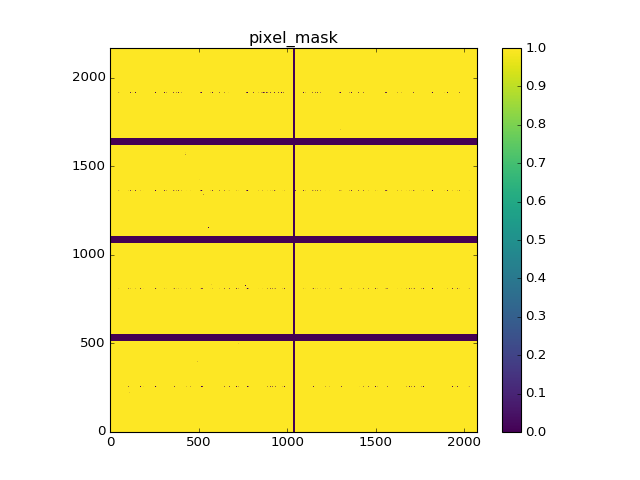

In [67]:
fig, ax = plt.subplots()
im = ax.imshow(imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis',origin='lower')
ax.set_title( 'pixel_mask')
fig.colorbar( im )
plt.show()

# show one image with pixel_mask

<IPython.core.display.Javascript object>


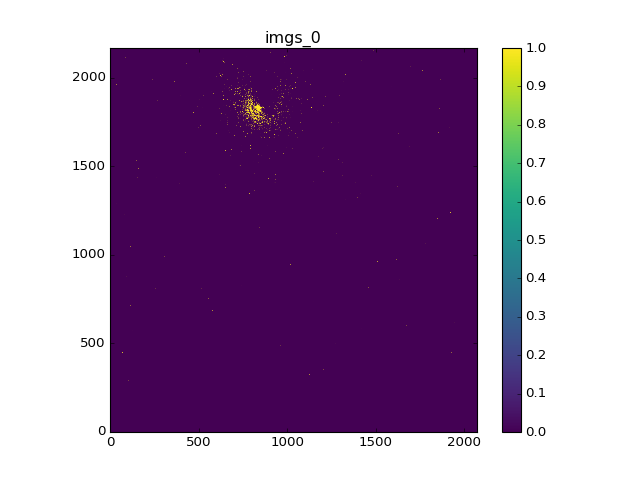

In [66]:
fig, ax = plt.subplots()
im = ax.imshow(imgs[0]*imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis',origin='lower')
ax.set_title( 'imgs_0')
fig.colorbar( im )
plt.show()

# Check bad images by waterfall plot

In [68]:
masker =Masker( imgs, imgs.md['pixel_mask'])

### Users put interested retangle here

In [181]:
rectangle = [ [1400, 800, 600, 1], ]  # corner y, x, length, width

In [182]:
roi_data = np.array((  rectangle ), dtype=np.int64)  
rect_array = roi.rectangles(roi_data, shape=imgs.shape) * imgs.md['pixel_mask']

<IPython.core.display.Javascript object>


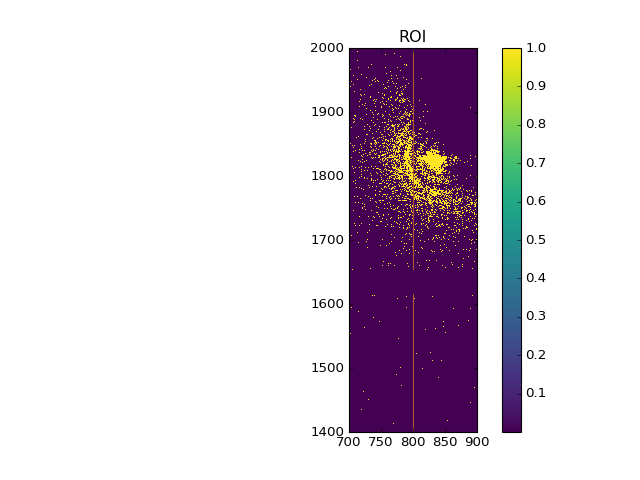

In [185]:
fig, axes = plt.subplots( )
axes.set_title("ROI")
im,im_label = show_label_array_on_image(axes, masker[0], rect_array, imshow_cmap='viridis', 
                cmap='Paired',    vmin=0.0001, vmax= 1, log_img=False, origin="lower")
#im = axes.imshow(rect_array, norm=LogNorm(0.001,1.0),cmap='viridis',origin='lower')

axes.set_xlim(  rectangle[0][1] -100, rectangle[0][1] +100  )
axes.set_ylim(  rectangle[0][0] -0, rectangle[0][0] + rectangle[0][2] )

fig.colorbar(im )
plt.show()

In [122]:
kymo = roi.kymograph( imgs[::1], rect_array, num = 1)

In [186]:
if False:
    fig, ax = plt.subplots( )
    ax.set_ylabel('Pixel')
    ax.set_xlabel('Frame')
    ax.set_title('Kymograph')
    ax.imshow(kymo.T, cmap='viridis', vmin=0.0001, vmax= 1, aspect=6.0)
    plt.show() 

<IPython.core.display.Javascript object>


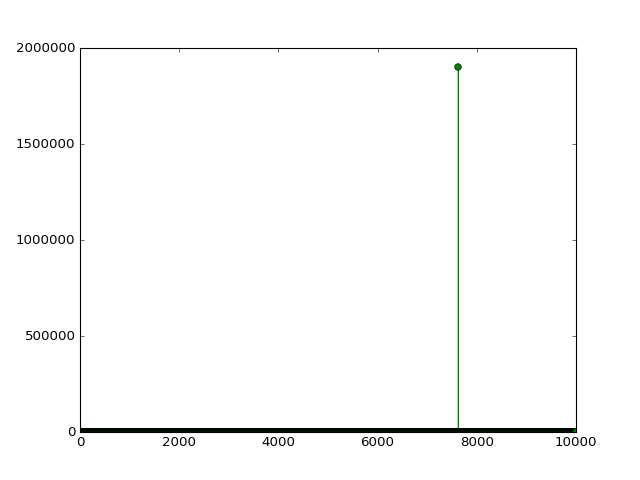

In [173]:
kymo_sum = np.sum( kymo, axis=1) 
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

## Remove hotspots in the image

In [40]:
hot= np.array([imgs[i].max() for i in np.random.random_integers(0, 200-1, 5)]).mean()

In [187]:
hot

65535.0

In [42]:
mask_rh  = RemoveHotSpots( masker, hot)._get_mask(Ns=0,Ne=10)

In [43]:
makser = Masker( imgs, imgs.md['pixel_mask']*mask_rh)

In [ ]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(mask_rh,  cmap='viridis',origin='lower', 
              norm= LogNorm( vmin=0.001, vmax=1e1 ) )

fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

In [190]:
(imgs[100]*imgs.md['pixel_mask']).max()

65535

In [191]:
(imgs[100]*imgs.md['pixel_mask'] *  mask_rh ).max()

3115

## Import all the required packages to create manual mask
xray-vision - plotting helper functions for X-ray science
https://github.com/Nikea/xray-vision

In [192]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

## Get the Averaged Image Data

In [195]:
good_start = 0
good_end= 7600

avg_img = np.average(imgs[good_start:good_end: 10], axis=0) #*imgs.md['pixel_mask']  #*mask_rh

In [196]:
avg_img =avg_img*imgs.md['pixel_mask']*mask_rh

<IPython.core.display.Javascript object>


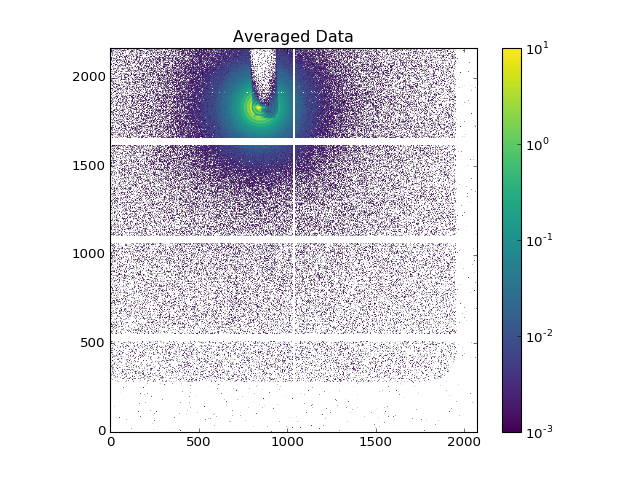

In [197]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img,  cmap='viridis',origin='lower', 
              norm= LogNorm( vmin=0.001, vmax=1e1 ) )

fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

# save ave_img data

In [199]:
np.save( path +  str(uid)+"_ave",avg_img ) 

## Create the mask file
More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

<IPython.core.display.Javascript object>


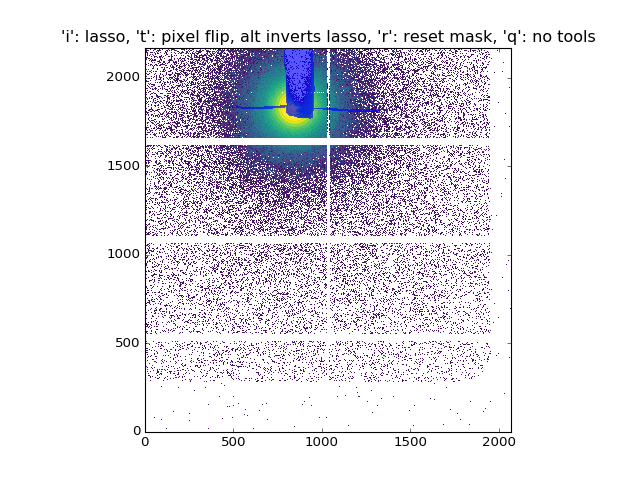

In [200]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img,
               cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e0 ) )
plt.show()

In [ ]:
#np.save( new_path + 'mask_SiO2',m.mask)

In [204]:
if load_ManuMask:
 
    new_mask = np.load( new_path +'mask_SiO2.npy' )
    
else:
    new_mask = m.mask
    
    

<IPython.core.display.Javascript object>


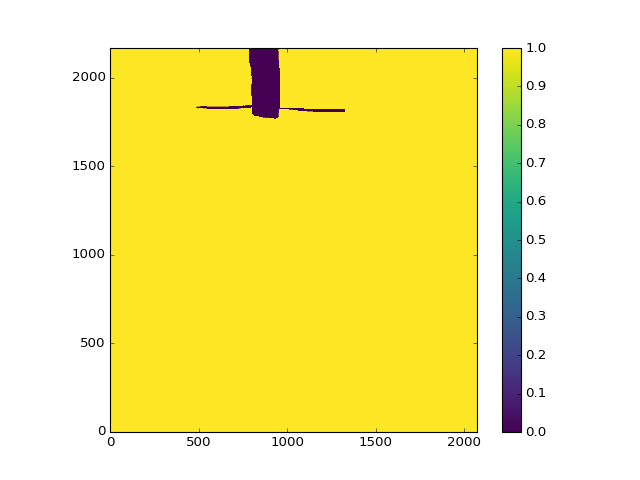

In [205]:

fig, ax = plt.subplots()
im=ax.imshow(~new_mask,origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Combine the hand-drawn mask and the pixel mask and hot pixel mask

In [ ]:
mask = (~new_mask)*imgs.md['pixel_mask']*mask_rh

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## save the combined mask to use in data analysis

In [ ]:
#np.save(str(uid)+"_mask", mask)

np.save(path + str(uid)+"_mask", imgs.md['pixel_mask']*mask_rh )

In [ ]:
np.save(path + str(uid)+"_mask", mask )